<a href="https://colab.research.google.com/github/alisharana/btc_prediction/blob/main/btc_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
#from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

#%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

#RANDOM_SEED = 42

#np.random.seed(RANDOM_SEED)

In [ ]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "/content/drive/MyDrive/BTC .csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
1489,2016-12-02,757.54,781.30,757.54,777.94,127605000,1.246294e+10
1488,2016-12-03,778.25,778.25,764.86,771.16,69547296,1.235581e+10
1487,2016-12-04,771.64,773.87,768.16,773.87,60557900,1.240077e+10
1486,2016-12-05,773.39,773.47,751.71,758.70,106363000,1.215912e+10
1485,2016-12-06,758.72,765.62,758.72,764.22,116218000,1.224909e+10


In [ ]:
df.shape

(1490, 7)

Text(0, 0.5, 'Close Price (USD)')

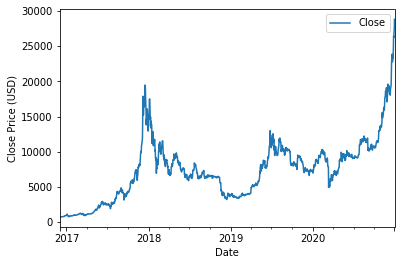

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df = df.astype('float32')

# Normalization

In [ ]:
#scaler = MinMaxScaler()

#close_price = df.Close.values.reshape(-1, 1)

#scaled_close = scaler.fit_transform(df)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [ ]:
dataset.shape

(1490, 6)

In [ ]:
#np.isnan(scaled_close).any()
dataset

array([[0.0000000e+00, 5.5657700e-04, 2.1910295e-04, 6.8513118e-04,
        9.9539792e-04, 5.7994574e-04],
       [7.7849813e-04, 4.4831447e-04, 4.9420446e-04, 4.4369511e-04,
        2.1192408e-04, 3.7546270e-04],
       [5.3002499e-04, 2.9284135e-04, 6.1822496e-04, 5.4019876e-04,
        9.0614485e-05, 4.6127476e-04],
       ...,
       [9.5942980e-01, 9.4502968e-01, 9.5668852e-01, 9.3746448e-01,
        6.6128165e-01, 9.3759006e-01],
       [9.8953927e-01, 9.4437695e-01, 9.4840771e-01, 9.4735074e-01,
        6.1012584e-01, 9.4748753e-01],
       [9.9999988e-01, 1.0000000e+00, 1.0000000e+00, 9.9999994e-01,
        6.9138432e-01, 1.0000001e+00]], dtype=float32)

In [ ]:
#scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
#scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
#np.isnan(scaled_close).any()

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(dataset, SEQ_LEN, train_split = 0.80)

In [ ]:
X_train.shape

(1112, 99, 6)

In [ ]:
X_test.shape

(278, 99, 6)

In [ ]:
X_test

array([[[0.24509117, 0.23359905, 0.2363793 , 0.22947375, 0.34884942,
         0.22579226],
        [0.24249932, 0.23045124, 0.23806074, 0.2300428 , 0.30471095,
         0.22637828],
        [0.2429485 , 0.22921987, 0.23906118, 0.22905786, 0.25989133,
         0.22545248],
        ...,
        [0.21347952, 0.21380714, 0.2126909 , 0.21280701, 0.6500158 ,
         0.21186337],
        [0.22483486, 0.21748061, 0.217421  , 0.21089336, 0.60100555,
         0.21000223],
        [0.22244596, 0.21190596, 0.21945156, 0.21215323, 0.475905  ,
         0.21126208]],

       [[0.24249932, 0.23045124, 0.23806074, 0.2300428 , 0.30471095,
         0.22637828],
        [0.2429485 , 0.22921987, 0.23906118, 0.22905786, 0.25989133,
         0.22545248],
        [0.24184334, 0.23968412, 0.24110714, 0.24046825, 0.31146806,
         0.23656201],
        ...,
        [0.22483486, 0.21748061, 0.217421  , 0.21089336, 0.60100555,
         0.21000223],
        [0.22244596, 0.21190596, 0.21945156, 0.21215323, 0.475

# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
16/16 [==============================] - 30s 979ms/step - loss: 0.0211 - val_loss: 0.0218
Epoch 2/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0100 - val_loss: 0.0088
Epoch 3/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0041 - val_loss: 0.0083
Epoch 4/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0051 - val_loss: 0.0094
Epoch 5/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0039 - val_loss: 0.0088
Epoch 6/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0035 - val_loss: 0.0097
Epoch 7/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0038 - val_loss: 0.0096
Epoch 8/50
16/16 [==============================] - 1s 53ms/step - loss: 0.0052 - val_loss: 0.0147
Epoch 9/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0053 - val_loss: 0.0181
Epoch 10/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0064 - val_loss: 0.0131
Epoch 1

In [ ]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 13s 710ms/step - loss: 0.0087


0.008707123808562756

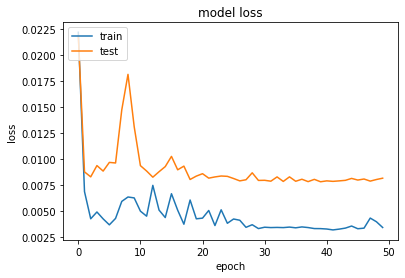

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
#scaler = MinMaxScaler()
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

NotFittedError: ignored

In [ ]:
y_hat_inverse

In [ ]:
y_test_inverse

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(y_hat_inverse)